In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

### expand_basis

In [151]:

def expand_basis(X, poly_deg, include_sin, include_log):
    """ Expands basis with polynomial, sine and logarithm functions

    Args:
        X (np.ndarray):
        poly_deg (int): Degree for polynomial expansion.
        include_sin (bool): Includes sine features if True else not.
        include_log (bool): Includes log features if True else not.

    Returns:
        np.ndarray: Expanded feature vector of shape (N, D').
    """
    # Z = expand_poly(X, p)
#     poly_expansion = PolynomialFeatures(degree=poly_deg)

    Z_ls = [expand_poly(X, poly_deg)]
#     Z_ls = [poly_expansion.fit_transform(X)]

    if include_sin:
        Z_ls.append(np.sin(X))

    if include_log:
        Z_ls.append(1 + np.log(np.where(X < 0, 0, X) + 1))

    Z = np.hstack(Z_ls)
    return Z


def expand_poly(X, p):
    """ Expands the polynomial basis of the input data

    Args:
        X (np.ndarray): Input data of shape (N, D).
        p (int): Polynomial Degree

    Returns:
        (np.ndarray): Expanded polynomial features.
    """
    N, dim = X.shape
    Z = np.hstack([np.ones((N, 1)), *[X ** i for i in range(1, p + 1)]])
    return Z


### Utils

In [152]:

def read_data():
    """ Reads the data for training and test

    It extracts training data inputs and labels from `traindata.txt` and test data inputs
    from `testinputs.txt`.

    Returns:
        np.ndarray: Input training data of shape (N, D).
        np.ndarray: Training data labels of shape (N, 1).
        np.ndarray: Input test data of shape (N', D).

    """
    df_train = pd.read_csv("traindata.txt", sep="   ", names=range(9), engine="python")

    df_train = df_train.sample(len(df_train))

    X_train = df_train.iloc[:, :-1].values
    y_train = df_train.iloc[:, -1].values.reshape(-1, 1)

    X_test = pd.read_csv("testinputs.txt", sep="   ", names=range(8), engine="python").values
    return X_train, y_train, X_test


def model_fit(Z, y):
    """ Fits Linear Regression model on the data

    Args:
        Z (np.ndarray): Feature engineered inputs of shape (N, D').
        y (np.ndarray): Corresponding data labels of shape (N, 1).

    Returns:
        np.ndarray: Weight for fitted linear regression model of shape (D', 1).

    """
    w = np.linalg.inv(Z.T @ Z) @ (Z.T @ y)
    # w = np.linalg.lstsq(Z.T @ Z, (Z.T @ y), rcond=None)
    return w


def all_train_fit(Xtrain, ytrain, basis):
    """ Trains Linear Regression model of the basis on the whole training data

    Args:
        Xtrain: Input training data of shape (N, D).
        ytrain: Corresponding data labels of shape (N, 1).
        basis: Basis with the least cross validation MSE loss with values (poly_degree, include_sin, include_log).

    Returns:
        np.ndarray: Weight for fitted linear regression model of shape (D', 1).

    """
    Ztrain = expand_basis(Xtrain, *basis)
    w = model_fit(Ztrain, ytrain)
    return w


def model_predict(Xtest, w_ls, basis):
    """ Runs model prediction on test data with the fitted linear regression weight

    Args:
        Xtest: Input test data of shape (N, D).
        w_ls: Weight for fitted linear regression model of shape (D', 1).
        basis: Basis with the least cross validation MSE loss with values (poly_degree, include_sin, include_log).

    Returns:
        np.ndarray: Labels predicted by the linear regerssion model on test data.

    """
    Ztest = expand_basis(Xtest, *basis)
    ytest_preds = Ztest @ w_ls
    return ytest_preds


def mse(y_true, y_pred):
    """ (float) Computes MSE loss between true and prediction values """
    return ((y_true.ravel() - y_pred.ravel()) ** 2).mean()

### cross validation

In [220]:

def cross_validation(Z, y, K):
    """ Applies cross validation to the data

    This module applies K-fold cross validation on the input data to avoid over-fitting on the data.
    It includes a parameter `K`, which is the number of folds to experiment on.

    Args:
        Z (np.ndarray): Feature engineered data of shape (N, D').
        y (np.ndarray): Regression labels array of shape (N, 1) .
        K (int): Number of folds to run cross validation on.

    Returns:
        float: mean MSE error for cross validation.
    """
    chunk_length = len(Z) // K

    sum_cross_val_loss = 0

    for k in range(K):
        test_start = k * chunk_length
        test_stop = (k + 1) * chunk_length

        Z_test = Z[test_start: test_stop, :]
        y_test = y[test_start: test_stop, :]

        Z_train = np.vstack((Z[: test_start, :], Z[test_stop:, :]))
        y_train = np.vstack((y[: test_start, :], y[test_stop:, :]))

        w = model_fit(Z_train, y_train)

        y_test_preds = Z_test @ w
        mse_test = mse(y_test, y_test_preds)
        sum_cross_val_loss += mse_test
        
        y_test_preds = Z_test @ w
        mse_test = mse(y_test, y_test_preds)
#         print("Train MSE: {train_mse}", mse_test)
        
    mean_cross_val_loss = sum_cross_val_loss / K
    return mean_cross_val_loss


### basis_expansion_chooser

In [293]:
def basis_expansion_chooser(X, y):
    """ Chooses basis on the based of cross validation error

    Args:
        X (np.ndarray): Input training data of shape (N, D).
        y (np.ndarray): Training data labels of shape (N, 1).

    Returns:
        tuple: Basis with the least cross validation MSE loss with values
        (poly_degree, include_sin, include_log).
    """
    least_R = np.inf
    basis = None

    K = 5

    poly_deg_ls = range(1, 10)
    include_sin_ls = [True, False]
    include_log_ls = [True, False]

    for _basis in itertools.product(include_log_ls, include_sin_ls, poly_deg_ls):  # only has polynomial expansion
        Z = expand_basis(X, *_basis)
#         print(_basis)
        mean_R = cross_validation(Z, y, K)

        if mean_R < least_R:
            least_R = mean_R
            basis = _basis

#         print(_basis, "MSE: ", mean_R)
        
        basis_cvmse.append([*_basis, mean_R])
#     print(f"Minimal MSE basis: {basis} Least MSE Loss: {least_R}")
    
    return basis, basis_cvmse


### main

In [310]:
basis_cvmse = []

for s_id in range(0, 20000000, 10000):
    np.random.seed(s_id)
    # 1234892, 23

    Xtrain, ytrain, Xtest = read_data()
    basis, basis_cvmse = basis_expansion_chooser(Xtrain, ytrain)
    w_ls = all_train_fit(Xtrain, ytrain, basis)
    ytest_preds = model_predict(Xtest, w_ls, basis)

#     print("\n", "Minimal MSE basis: ", basis)
#     print("Train MSE loss:", mse(ytrain, model_predict(Xtrain, w_ls, basis)))
    print("\r", s_id, end="")

 19990000

### visualization

In [311]:
df_results = pd.DataFrame(basis_cvmse, columns=["include log basis", "include sin basis", "polynomial basis degree", "MSE"])
df_results["log10 MSE"] = np.log10(df_results["MSE"])
df_results["sin and log basis"] = df_results.apply(lambda x: f"log: {x['include log basis']}, sin: {x['include sin basis']}", axis=1)

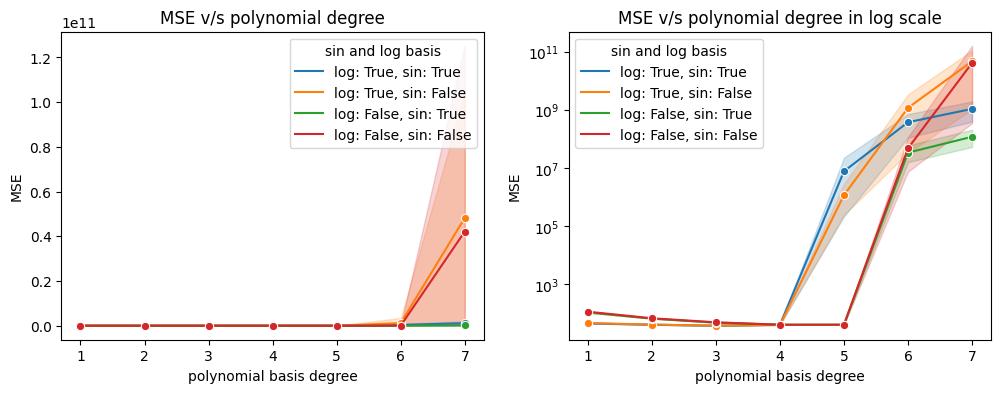

[None]

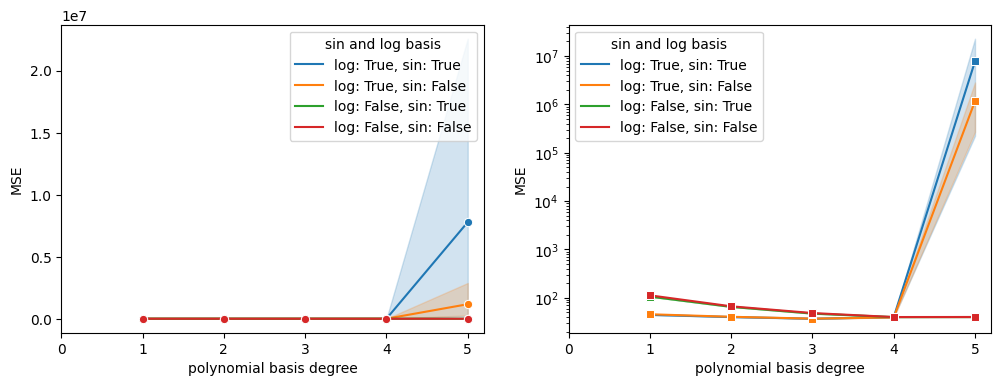

In [455]:

fig, (ax1, ax2) = plt.subplots(
    figsize=(12, 4),
    ncols=2
)

sns.lineplot(
    df_results[df_results["polynomial basis degree"] < 8], 
    x="polynomial basis degree", 
    y="MSE",
    hue="sin and log basis",
    marker="o",
    errorbar=('ci', 95),
    err_style='band',
    ax=ax1
)
ax1.set_title("MSE v/s polynomial degree")


sns.lineplot(
    df_results[df_results["polynomial basis degree"] < 8],
    x="polynomial basis degree", 
    y="MSE",
    hue="sin and log basis",
    marker="o",
    err_style='band',
    errorbar=('ci', 95),
    ax=ax2
)
ax2.set(yscale="log")
ax2.set_title("MSE v/s polynomial degree in log scale")

plt.show()

fig, (ax1, ax2) = plt.subplots(
    figsize=(12, 4),
    ncols=2
)

sns.lineplot(
    df_results[df_results["polynomial basis degree"] < 6], 
    x="polynomial basis degree", 
    y="MSE",
    hue="sin and log basis",
    marker="o",
    errorbar=('ci', 95),
    err_style='band',
    ax=ax1
)
ax1.set_xticks(range(6))

sns.lineplot(
    df_results[df_results["polynomial basis degree"] < 6], 
    x="polynomial basis degree", 
    y="MSE",
    hue="sin and log basis",
    marker="s",
    err_style='band',
    errorbar=('ci', 95),
    ax=ax2
)
ax2.set_xticks(range(6))
ax2.set(yscale="log")


In [324]:
df_results[(df_results["polynomial basis degree"] == 5) & (df_results["sin and log basis"] == "log: True, sin: True")].describe()

,polynomial basis degree,MSE,log10 MSE
count,2000.0,2.000000e+03,2000.000000
mean,5.0,7.784984e+06,3.898140
std,0.0,3.204197e+08,0.832970
min,5.0,2.908662e+02,2.463693
25%,5.0,2.031676e+03,3.307854
50%,5.0,5.179793e+03,3.714312
75%,5.0,1.915440e+04,4.282268
max,5.0,1.431225e+10,10.155708


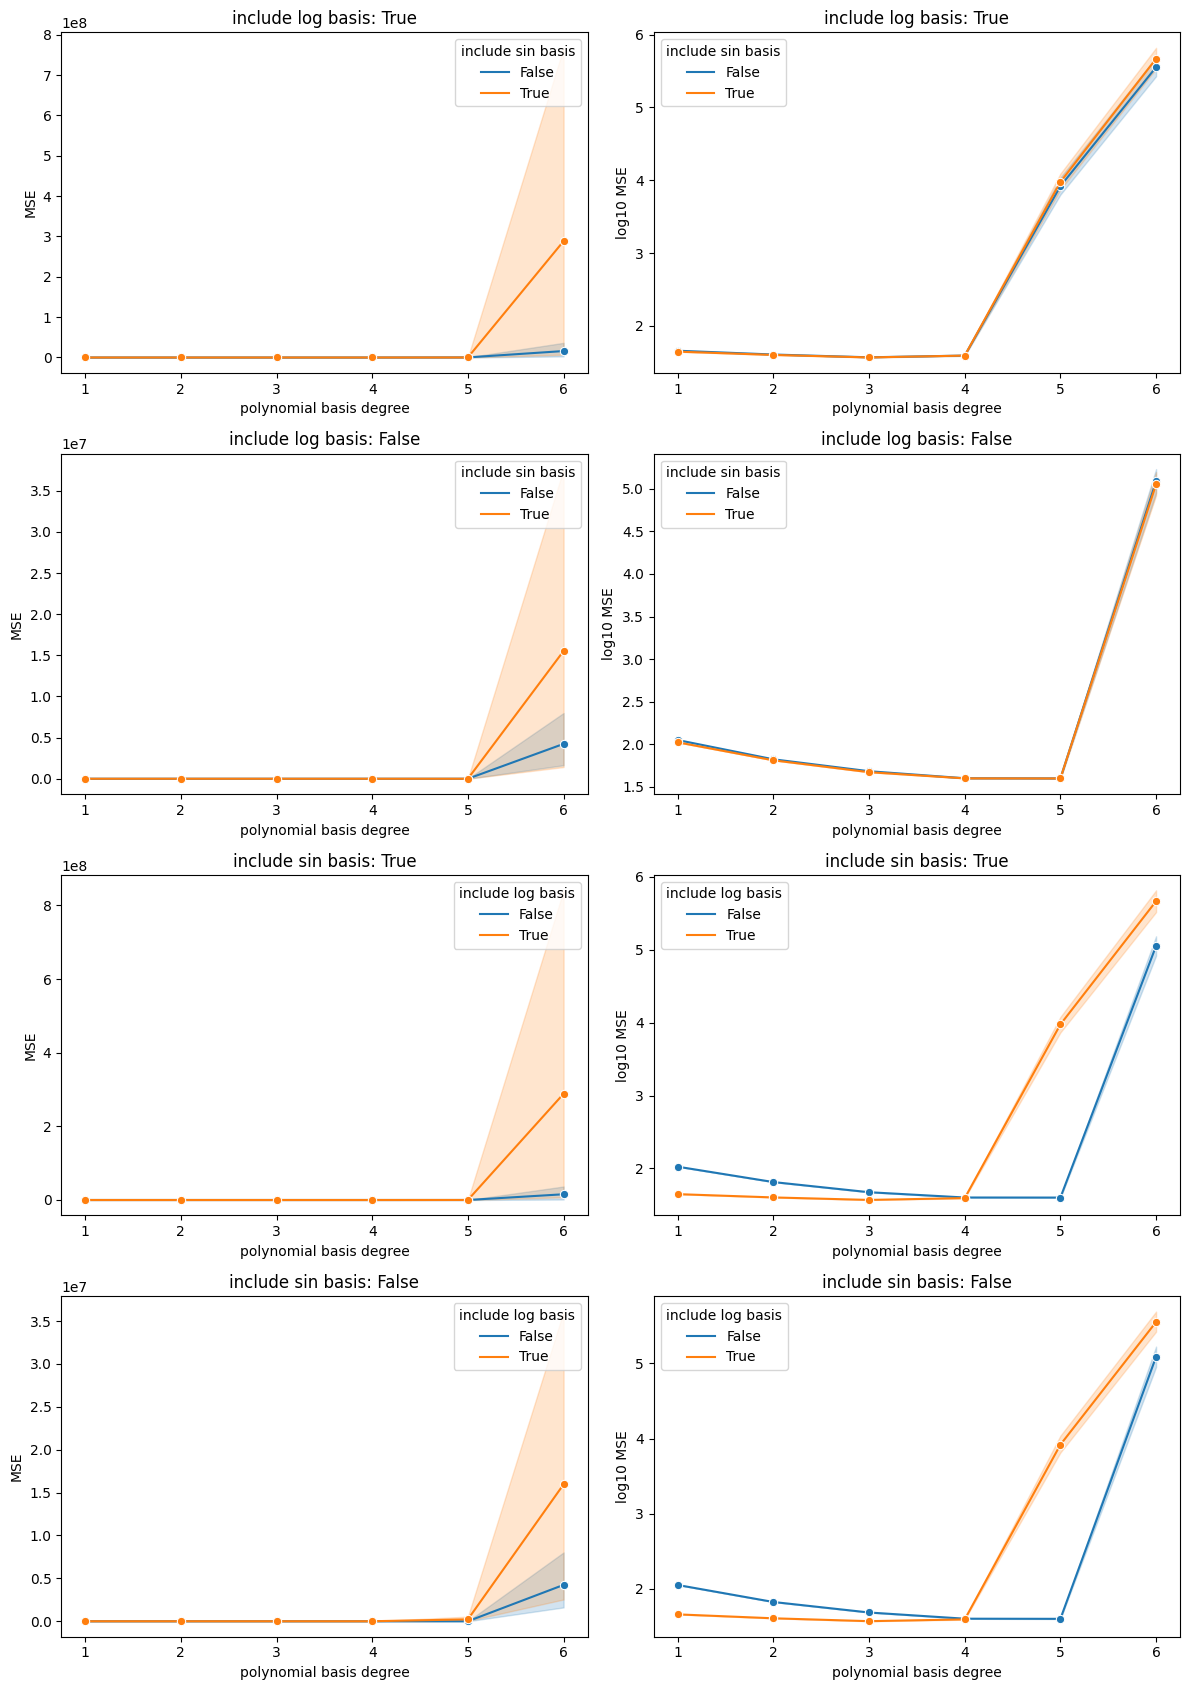

In [247]:
fig, axs = plt.subplots(
    figsize=(12, 17),
    ncols=2,
    nrows=4,
)

features = ["include log basis", "include sin basis"]
feature_values = [True, False]

for idx, (feat, feat_val) in enumerate(itertools.product(features, feature_values)):
    hue_feat = f"include {'log' if 'sin' in feat else 'sin'} basis"
    sns.lineplot(
        df_results[df_results[feat] == feat_val], 
        x="polynomial basis degree", 
        y="MSE",
        hue=hue_feat,
        marker="o",
        ax=axs[idx][0],
    ).set_title(f"{feat}: {feat_val}")

    sns.lineplot(
        df_results[df_results[feat] == feat_val], 
        x="polynomial basis degree", 
        y="log10 MSE",
        hue=hue_feat,
        marker="o",
        ax=axs[idx][1],
    ).set_title(f"{feat}: {feat_val}")

fig.tight_layout()
plt.show()

### Sklearn

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
model = LinearRegression()
model.fit(Xtrain, ytrain)
ytest = model.predict(Xtest)

In [ ]:
ytrain_ = model.predict(Xtrain)

In [ ]:
mse(ytrain, ytrain_)

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
cv = KFold()

In [ ]:
df_train = pd.read_csv("traindata.txt", sep="   ", names=range(9), engine="python")
data_train = df_train.values

In [ ]:
for train_idx, test_idx in cv.split(data_train):
    d_train = data_train[train_idx]
    d_test = data_train[test_idx]
    X_train, y_train = d_train[:, :-1], d_train[:, -1]
    X_test, y_test = d_test[:, :-1], d_test[:, -1]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    mse_train = mse(y_train, model.predict(X_train))
    mse_test = mse(y_test, model.predict(X_test))
    print(mse_train, mse_test)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer

In [ ]:
feature_eng1 = PolynomialFeatures(degree=2)

X_temp = data_train.copy()[:, :-1]
data_train1 = feature_eng1.fit_transform(X_temp)
data_train2 = np.sin(X_temp)
data_train3 = np.log(X_temp + 1)

data_train_ = np.hstack([
    data_train1,
    data_train2, 
    data_train3, 
    data_train[:, -1].reshape(-1, 1)])

# data_train_ = np.hstack([
#     Z, 
#     y])

In [ ]:
# np.random.shuffle(data_train_)

In [ ]:
t = 0
for train_idx, test_idx in cv.split(data_train_):
    print(test_idx)
    d_train = data_train_[train_idx]
    d_test = data_train_[test_idx]
    X_train, y_train = d_train[:, :-1], d_train[:, -1]
    X_test, y_test = d_test[:, :-1], d_test[:, -1]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    mse_train = mse(y_train, model.predict(X_train))
    mse_test = mse(y_test, model.predict(X_test))
    print(mse_train, mse_test)
    t += mse_test
t / 5

In [ ]:
Z = expand_basis(Xtrain, *basis[::-1])
y = ytrain

In [ ]:
data_train_

In [ ]:
Z

In [ ]:
t = 0
K = 5
chunk_length = len(Z) // K

sum_cross_val_loss = 0
for k in range(K):
    test_start = k * chunk_length
    test_stop = (k + 1) * chunk_length

    Z_test = Z[test_start: test_stop, :]
    y_test = y[test_start: test_stop, :]

    Z_train = np.vstack((Z[: test_start, :], Z[test_stop:, :]))
    y_train = np.vstack((y[: test_start, :], y[test_stop:, :]))

    model = LinearRegression()
    model.fit(Z_train, y_train)
    
    mse_train = mse(y_train, model.predict(Z_train))

    mse_test = mse(y_test, model.predict(Z_test))
    
    print(f"Train MSE: {mse_train}, Test MSE: {mse_test}")
    t += mse_test
t / 5

In [ ]:
t = 0

for k in range(K):
    test_start = k * chunk_length
    test_stop = (k + 1) * chunk_length

    Z_test = Z[test_start: test_stop, :]
    y_test = y[test_start: test_stop, :]

    Z_train = np.vstack((Z[: test_start, :], Z[test_stop:, :]))
    y_train = np.vstack((y[: test_start, :], y[test_stop:, :]))

    w = model_fit(Z_train, y_train)
    
    y_test_preds = Z_test @ w
    mse_test = mse(y_test, y_test_preds)
    
    y_train_preds = Z_train @ w
    mse_train = mse(y_train, y_train_preds)
    
    print(f"Train MSE: {mse_train}, Test MSE: {mse_test}")
    t += mse_test
t / 5

In [ ]:
model = LinearRegression()
model.fit(expand_basis(Xtrain, *basis), ytrain)
    
mse(ytrain, model.predict(expand_basis(Xtrain, *basis)))

In [ ]:
model = LinearRegression()
model.fit(data_train_[:, :-1], data_train_[:, -1])
    
mse(data_train_[:, -1], model.predict(data_train_[:, :-1]))

In [ ]:
data_train_[:, -1].shape, y_train.shape

In [39]:
model = LinearRegression()
model.fit(Xtrain, ytrain)
ytest = model.predict(Xtest)

In [40]:
ytrain_ = model.predict(Xtrain)

In [41]:
mse(ytrain, ytrain_)

109.30570665237538

In [335]:
from sklearn.model_selection import KFold

In [336]:
cv = KFold()

In [370]:
df_train = pd.read_csv("traindata.txt", sep="   ", names=range(9), engine="python")
data_train = df_train.values

In [338]:
for train_idx, test_idx in cv.split(data_train):
    d_train = data_train[train_idx]
    d_test = data_train[test_idx]
    X_train, y_train = d_train[:, :-1], d_train[:, -1]
    X_test, y_test = d_test[:, :-1], d_test[:, -1]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    mse_train = mse(y_train, model.predict(X_train))
    mse_test = mse(y_test, model.predict(X_test))
    print(mse_train, mse_test)

91.08574195217435 220.94513413277215
102.26413132829845 155.72737732420993
107.6472598414298 125.29487389324021
116.26232852252723 87.80116611718823
118.8361478932187 81.5875452387761


In [371]:
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer

In [372]:
feature_eng1 = PolynomialFeatures(degree=2)

X_temp = data_train.copy()[:, :-1]
data_train1 = feature_eng1.fit_transform(X_temp)
data_train2 = np.sin(X_temp)
data_train3 = np.log(X_temp + 1)

data_train_ = np.hstack([
    data_train1,
    data_train2, 
    data_train3, 
    data_train[:, -1].reshape(-1, 1)])

# data_train_ = np.hstack([
#     Z, 
#     y])

In [415]:
np.random.shuffle(data_train_)

t = 0
for train_idx, test_idx in cv.split(data_train_):
    d_train = data_train_[train_idx]
    d_test = data_train_[test_idx]
    X_train, y_train = d_train[:, :-1], d_train[:, -1]
    X_test, y_test = d_test[:, :-1], d_test[:, -1]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    mse_train = mse(y_train, model.predict(X_train))
    mse_test = mse(y_test, model.predict(X_test))
    print(mse_train, mse_test)
    t += mse_test
t / 5

28.66781645283255 42.1009341855376
126.06440863291502 126.52501416130868
29.690955830872852 34.773973084698554
126.60976866681943 148.90908362900242
82.07388994895643 69.33085524874947


84.32797206185934

### Ensemble

In [424]:
from sklearn import ensemble

In [425]:
np.random.shuffle(data_train_)

t = 0
for train_idx, test_idx in cv.split(data_train_):
    d_train = data_train_[train_idx]
    d_test = data_train_[test_idx]
    X_train, y_train = d_train[:, :-1], d_train[:, -1]
    X_test, y_test = d_test[:, :-1], d_test[:, -1]
    
    model = ensemble.RandomForestRegressor()
    model.fit(X_train, y_train)
    
    mse_train = mse(y_train, model.predict(X_train))
    mse_test = mse(y_test, model.predict(X_test))
    print(mse_train, mse_test)
    t += mse_test
t / 5

4.904642038697334 21.733433498479364
3.8895891023453832 32.62133273127295
4.817784284611261 28.090501163232144
4.740705035262617 22.512425249352397
5.1382359008581036 23.391152518448575


25.669769032157085

In [426]:
np.random.shuffle(data_train_)

t = 0
for train_idx, test_idx in cv.split(data_train_):
    d_train = data_train_[train_idx]
    d_test = data_train_[test_idx]
    X_train, y_train = d_train[:, :-1], d_train[:, -1]
    X_test, y_test = d_test[:, :-1], d_test[:, -1]
    
    model = ensemble.ExtraTreesRegressor()
    model.fit(X_train, y_train)
    
    mse_train = mse(y_train, model.predict(X_train))
    mse_test = mse(y_test, model.predict(X_test))
    print(mse_train, mse_test)
    t += mse_test
t / 5

1.12904009009009 31.232197117395472
1.4839055105713 18.21405969545944
0.25446743139901024 29.379185489948952
1.4974561853351323 16.32912854876125
0.7696380567071525 24.65451229218915


23.961816628750853

In [435]:
np.random.shuffle(data_train_)

t = 0
for train_idx, test_idx in cv.split(data_train_):
    d_train = data_train_[train_idx]
    d_test = data_train_[test_idx]
    X_train, y_train = d_train[:, :-1], d_train[:, -1]
    X_test, y_test = d_test[:, :-1], d_test[:, -1]
    
    model = ensemble.AdaBoostRegressor()
    model.fit(X_train, y_train)
    
    mse_train = mse(y_train, model.predict(X_train))
    mse_test = mse(y_test, model.predict(X_test))
    print(mse_train, mse_test)
    t += mse_test
t / 5

36.02263815740498 51.34978794428017
33.32927362279637 51.9160900908543
37.28971784860777 41.41460041576017
37.70312775214034 47.77834855397541
38.544759339666314 46.12469029480161


47.71670345993433

In [438]:
np.random.shuffle(data_train_)

t = 0
for train_idx, test_idx in cv.split(data_train_):
    d_train = data_train_[train_idx]
    d_test = data_train_[test_idx]
    X_train, y_train = d_train[:, :-1], d_train[:, -1]
    X_test, y_test = d_test[:, :-1], d_test[:, -1]
    
    model = ensemble.BaggingRegressor()
    model.fit(X_train, y_train)
    
    mse_train = mse(y_train, model.predict(X_train))
    mse_test = mse(y_test, model.predict(X_test))
    print(mse_train, mse_test)
    t += mse_test
t / 5

6.69415214459772 27.560753322845645
5.9912982383799 31.246255074373344
7.094329544249756 23.165358970962487
6.355563150649271 29.942078196546554
6.224510170945044 29.555724557966972


28.294034024539002

In [440]:
np.random.shuffle(data_train_)

t = 0
for train_idx, test_idx in cv.split(data_train_):
    d_train = data_train_[train_idx]
    d_test = data_train_[test_idx]
    X_train, y_train = d_train[:, :-1], d_train[:, -1]
    X_test, y_test = d_test[:, :-1], d_test[:, -1]
    
    model = ensemble.GradientBoostingRegressor()
    model.fit(X_train, y_train)
    
    mse_train = mse(y_train, model.predict(X_train))
    mse_test = mse(y_test, model.predict(X_test))
    print(mse_train, mse_test)
    t += mse_test
t / 5

9.478500017354936 25.491790708300307
9.583932228180025 22.254000585183686
8.881114250456628 29.452708018349803
10.175681631201124 20.546611780602046
10.345731465360402 30.953027475691105


25.73962771362539

In [442]:
np.random.shuffle(data_train_)

t = 0
for train_idx, test_idx in cv.split(data_train_):
    d_train = data_train_[train_idx]
    d_test = data_train_[test_idx]
    X_train, y_train = d_train[:, :-1], d_train[:, -1]
    X_test, y_test = d_test[:, :-1], d_test[:, -1]
    
    model = ensemble.HistGradientBoostingRegressor()
    model.fit(X_train, y_train)
    
    mse_train = mse(y_train, model.predict(X_train))
    mse_test = mse(y_test, model.predict(X_test))
    print(mse_train, mse_test)
    t += mse_test
t / 5

2.6726362620577233 22.384873534035865
2.703362062702331 20.522644307738833
1.7567660255365964 26.630205268905538
2.7804803121165933 19.24038850233252
2.5743917267508825 17.917521028994315


21.339126528401415

In [445]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [448]:
np.random.shuffle(data_train_)

t = 0
for train_idx, test_idx in cv.split(data_train_):
    d_train = data_train_[train_idx]
    d_test = data_train_[test_idx]
    X_train, y_train = d_train[:, :-1], d_train[:, -1]
    X_test, y_test = d_test[:, :-1], d_test[:, -1]
    
    model = GaussianProcessRegressor()
    model.fit(X_train, y_train)
    
    mse_train = mse(y_train, model.predict(X_train))
    mse_test = mse(y_test, model.predict(X_test))
    print(mse_train, mse_test)
    t += mse_test
t / 5

1.2643395720724695 1469.3732794151267
0.38502429149818096 1533.4672298249068
1.2527200854704434 1529.90308937384
1.3859507422406814 1289.2709505317532
1.1518889563657153 1202.8614611635987


1404.975202061845

In [449]:
from sklearn.neighbors import KNeighborsRegressor

In [454]:
np.random.shuffle(data_train_)

t = 0
for train_idx, test_idx in cv.split(data_train_):
    d_train = data_train_[train_idx]
    d_test = data_train_[test_idx]
    X_train, y_train = d_train[:, :-1], d_train[:, -1]
    X_test, y_test = d_test[:, :-1], d_test[:, -1]
    
    model = KNeighborsRegressor()
    model.fit(X_train, y_train)
    
    mse_train = mse(y_train, model.predict(X_train))
    mse_test = mse(y_test, model.predict(X_test))
    print(mse_train, mse_test)
    t += mse_test
t / 5

60.215534102702705 100.75875473118279
58.10467421322538 101.25520983783784
62.903957052631576 79.72610592432432
60.21460360593792 88.19558871351352
60.872137139001346 89.55738823783784


91.89860948893927

In [421]:
Z = expand_basis(Xtrain, *basis[::-1])
y = ytrain

In [422]:
t = 0
K = 5
chunk_length = len(Z) // K

sum_cross_val_loss = 0
for k in range(K):
    test_start = k * chunk_length
    test_stop = (k + 1) * chunk_length

    Z_test = Z[test_start: test_stop, :]
    y_test = y[test_start: test_stop, :]

    Z_train = np.vstack((Z[: test_start, :], Z[test_stop:, :]))
    y_train = np.vstack((y[: test_start, :], y[test_stop:, :]))

    model = LinearRegression()
    model.fit(Z_train, y_train)
    
    mse_train = mse(y_train, model.predict(Z_train))

    mse_test = mse(y_test, model.predict(Z_test))
    
    print(f"Train MSE: {mse_train}, Test MSE: {mse_test}")
    t += mse_test
t / 5

Train MSE: 32.386722022107335, Test MSE: 37.60367352036881
Train MSE: 32.527989295826174, Test MSE: 36.985304313913325
Train MSE: 29.910447018185604, Test MSE: 47.98335969544243
Train MSE: 33.93931529436305, Test MSE: 30.835965995503038
Train MSE: 33.25867380389715, Test MSE: 34.492071862706744


37.58007507758687

In [345]:
t = 0

for k in range(K):
    test_start = k * chunk_length
    test_stop = (k + 1) * chunk_length

    Z_test = Z[test_start: test_stop, :]
    y_test = y[test_start: test_stop, :]

    Z_train = np.vstack((Z[: test_start, :], Z[test_stop:, :]))
    y_train = np.vstack((y[: test_start, :], y[test_stop:, :]))

    w = model_fit(Z_train, y_train)
    
    y_test_preds = Z_test @ w
    mse_test = mse(y_test, y_test_preds)
    
    y_train_preds = Z_train @ w
    mse_train = mse(y_train, y_train_preds)
    
    print(f"Train MSE: {mse_train}, Test MSE: {mse_test}")
    t += mse_test
t / 5

Train MSE: 32.182141728435624, Test MSE: 35.68069284655524
Train MSE: 33.05169654665078, Test MSE: 36.28981015444176
Train MSE: 29.819971306945224, Test MSE: 47.4672070283146
Train MSE: 33.803473329995896, Test MSE: 30.439502772254198
Train MSE: 33.984109438401276, Test MSE: 34.94853614963293


36.96514979023975

In [332]:
model = LinearRegression()
model.fit(expand_basis(Xtrain, *basis), ytrain)
    
mse(ytrain, model.predict(expand_basis(Xtrain, *basis)))

43.121067750164954

In [333]:
model = LinearRegression()
model.fit(data_train_[:, :-1], data_train_[:, -1])
    
mse(data_train_[:, -1], model.predict(data_train_[:, :-1]))

NameError: name 'data_train_' is not defined

In [21]:
data_train_[:, -1].shape, y_train.shape

((926,), (741,))